# Purpose

The purpose of this project is to develop a deep learning model that can imitate the artstyle of Claude Monet and produce 7,000-10,000 Monet-style images. I will be doing so by implementing a generative adversarial network (GAN) which typically consists of at least two neural networks: a generator model and a discriminator model. The generator creates images which is trained by the discriminator. The two models will work against each other, hence the "adversarial" model name, where the generator will mix up sending real and generated images and the discriminator will need to accurately classify images into the two groups. Specifically this notebook will be implementing CycleGan which performs style transfer for images. 

This project is being worked on with the intent to submit to the ["I'm something of a painter myself"](https://www.kaggle.com/competitions/gan-getting-started/overview) rolling kaggle competition. Much initialization and inspiration for cycleGAN implementation will be taken from [Amy Jang's notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook)

## Import necessary libraries and set up notebook environment

In [1]:
#clear kaggle output 
!rm -rf /kaggle/working/*

In [2]:
!pip install tensorflow-addons[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.4
    Uninstalling keras-3.0.4:
      Successfully uninstalled keras-3.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.7.0 requires keras-core, which is not installed.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow version:", tf.__version__)
print("TensorFlow Addons version:", tfa.__version__)

TensorFlow version: 2.15.0
TensorFlow Addons version: 0.23.0


/usr/local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras import layers


AUTOTUNE = tf.data.AUTOTUNE

# import sklearn
# from sklearn.model_selection import train_test_split

In [5]:
# Detect hardware and light up the GPUs/TPUs
#code implemented from https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
try:
     # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

except ValueError: # If TPU not found
    tpu = None
    strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
    print('Running on CPU instead')

print("Number of accelerators: ", strategy.num_replicas_in_sync)
print("TPU: ", tpu)

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-02-26 00:02:41.198696: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:02:41.198819: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:02:41.198904: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:02:41.198988: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:02:41.199064: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:02:41.199282: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:02:41.199421: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [6]:
#check current directory, change if necessary
parent_path = "/kaggle/input/gan-getting-started"
monet_imgpath = "/kaggle/input/gan-getting-started/monet_jpg"
monet_tfrecpath = "/kaggle/input/gan-getting-started/monet_tfrec"
photo_imgpath = "/kaggle/input/gan-getting-started/photo_jpg"
photo_tfrecpath = "/kaggle/input/gan-getting-started/photo_tfrec"

os.chdir(parent_path)
print(os.getcwd())

/kaggle/input/gan-getting-started


## Import data

Based on the competition file structure, we have 2 sets of data. The "Monet" and "Photo" set which both consistes of a jpg folder filled with images and a TFRecords folder filled with the filenames of the associated images.



In [7]:
#how much data are we dealing with
print("# of images in Monet folder:", len(os.listdir(monet_imgpath)))
print("# of images in Photo folder:", len(os.listdir(photo_imgpath)))

# of images in Monet folder: 300
# of images in Photo folder: 7038


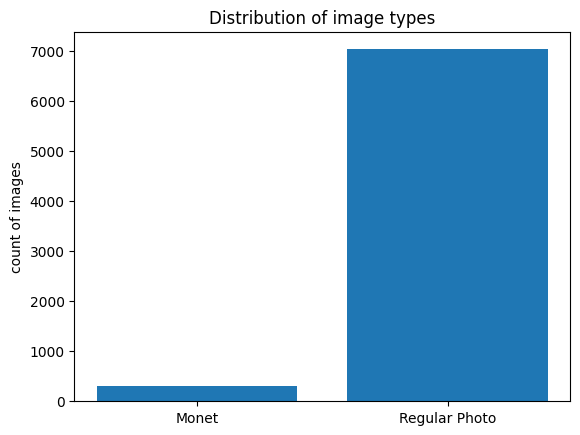

In [8]:
fig, ax = plt.subplots()

photo_type = ['Monet', 'Regular Photo']
counts = [300, 7038]

ax.bar(photo_type, counts)

ax.set_ylabel('count of images')
ax.set_title('Distribution of image types')

plt.show()

Here we see that we have 300 Monet sample images and 7038 sample realistic photos. Let's load a sample of what the images look like, understand the size of the images, and confirm RGB channels.

Typical Monet image properties
image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Converted image array datatype: float32
Array shape: (256, 256, 3)


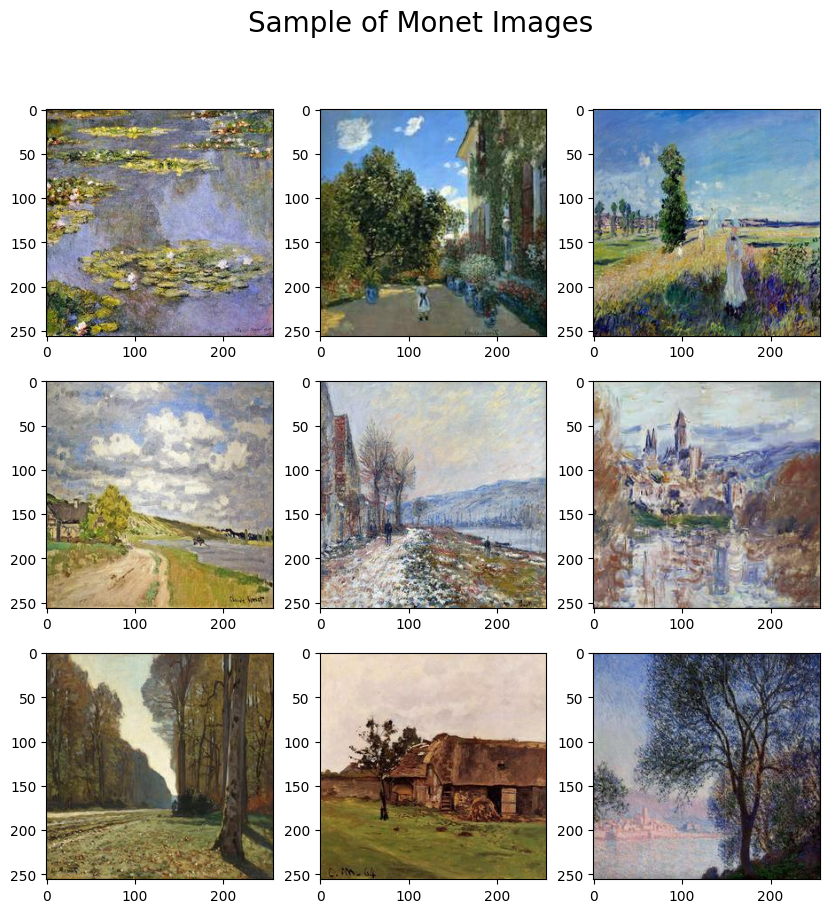

In [9]:
#go into Monet folder
os.chdir(monet_imgpath)
dir_list = os.listdir(monet_imgpath)
#display typical training images
print("Typical Monet image properties")
img = load_img(dir_list[0])
print("image type:", type(img))
img_array = img_to_array(img)
print("Converted image array datatype:", img_array.dtype)
print("Array shape:", img_array.shape)

fig, axs = plt.subplots(3,3,figsize=(10, 10))
h = 0
v = 0
for i in range(0,9):
    img = load_img(dir_list[i])
    axs[h,v].imshow(img)
    if h == 2:
        v +=1
        h = 0
    else: 
        h += 1
fig.suptitle("Sample of Monet Images", fontsize = 20)
plt.show()

Typical Photo image properties
image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Converted image array datatype: float32
Array shape: (256, 256, 3)


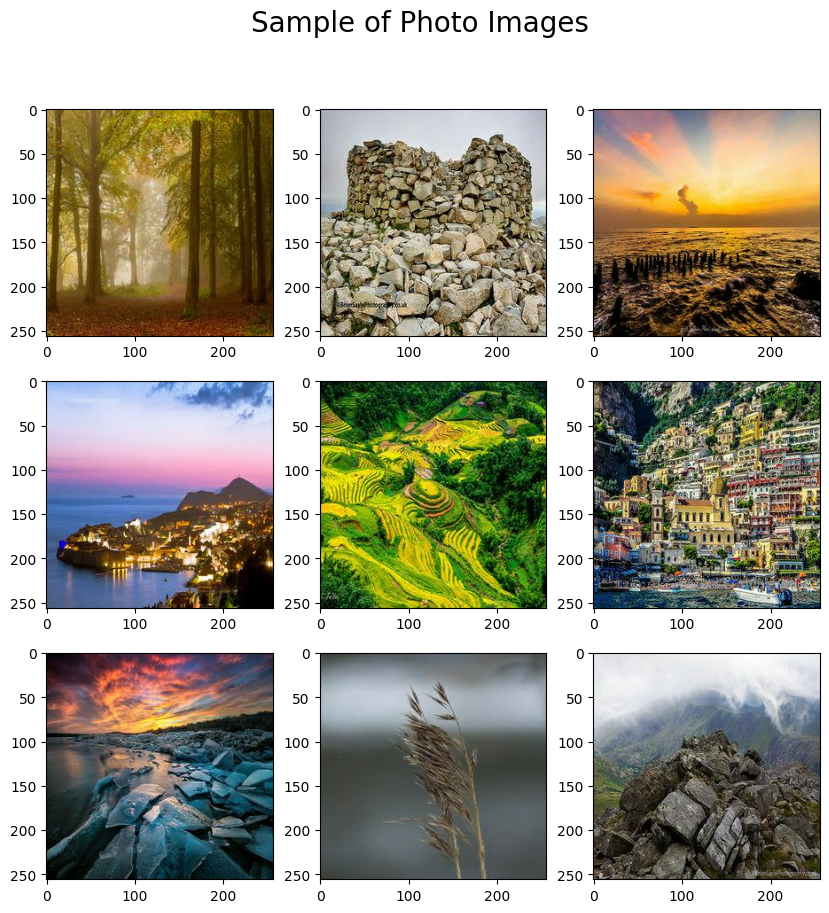

In [10]:
#go into Photo folder
os.chdir(photo_imgpath)
dir_list = os.listdir(photo_imgpath)
#display typical training images
print("Typical Photo image properties")
img = load_img(dir_list[0])
print("image type:", type(img))
img_array = img_to_array(img)
print("Converted image array datatype:", img_array.dtype)
print("Array shape:", img_array.shape)

fig, axs = plt.subplots(3,3,figsize=(10, 10))
h = 0
v = 0
for i in range(0,9):
    img = load_img(dir_list[i])
    axs[h,v].imshow(img)
    if h == 2:
        v +=1
        h = 0
    else: 
        h += 1
fig.suptitle("Sample of Photo Images", fontsize = 20)
plt.show()

From this we have discovered the images are in the shape 256x256 with RGB channels. Next let's load the filenames from the TFRecords for use in future mapping which will allow us to extract images.

In [11]:
#Load filenames from TFRecords
os.chdir(parent_path)
mon_filenames = tf.io.gfile.glob(str(monet_tfrecpath+'/*.tfrec'))
print("# of Monet TFRecord files:", len(mon_filenames))

pho_filenames = tf.io.gfile.glob(str(photo_tfrecpath+'/*.tfrec'))
print("# of Photo TFRecord files:", len(pho_filenames))

# of Monet TFRecord files: 5
# of Photo TFRecord files: 20


# Data Preprocessing
Here we implement helper functions from Amy Jang's notebook for decoding the images and reading the TFRecords. Additionally, we implemented data augmentation to help increase amount of data the model can train from.

In [12]:
#implement helper functions for decoding images, reading TFrecords, and loading the datasets. Adapted from https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
#data augmentation (artificially generating new data from existing data,to additionally train models.) be useful? 
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMAGE_SIZE = [256, 256]
# data aug options:  

def random_crop(image):
    cropped_image = tf.image.random_crop(
        image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

    return cropped_image

def random_jitter(image):
  # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

  # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image


def decode_image(image):
    #channel set to 3 for RGB
    image = tf.image.decode_jpeg(image, channels=3)
    #normalize scale to [-1,1] scale (best for 0 centric activation functions(tanh))
    # can try out normalize scale to [0,1] scale (best for non-0 centric activation functions (sigmoid))
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    #reshapes the input image tensor to the specified size with 3 color channels
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    #if adding data aug, replace above code with below, and uncomment previous random_crop & random_jitter functions
    image = random_jitter(image)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset

In [13]:
#create datasets
mon_ds = load_dataset(mon_filenames, labeled = True)
pho_ds = load_dataset(pho_filenames, labeled = True)

In [14]:
#confirm mapping was successful
example_monet = next(iter(mon_ds))
example_photo = next(iter(pho_ds))

Array shape: (256, 256, 3)
Array shape: (256, 256, 3)


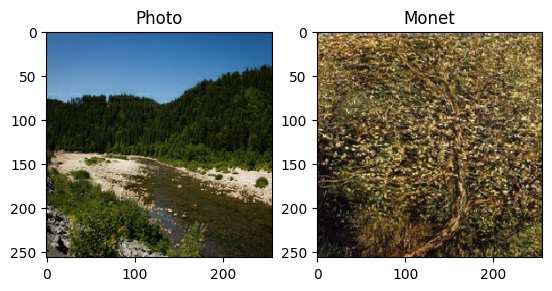

In [15]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)
print("Array shape:",img_to_array(example_photo[0]).shape)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)
print("Array shape:",img_to_array(example_monet[0]).shape)

# Build the Generator

This CycleGAN model will be utilizing UNET architecture for the Generator, which consists of an encoder (downsampler) and decoder (upsampler). 

The downsampler works to reduces the width and height of the image by the stride factor (i.e length of the step the filter takes). In this instance, we have set the stride to 2, therefore the filter is applied to every other pixel. Strides of 4 were also tride, however with worsening performance so I decided to stick with 2. Each block in the encoder is: Convolution ->  Instance normalization -> Leaky ReLU

The upsampler increases the dimensions of the of the image, expanding the width & height of image by the stridefactor. This is accomplished by tensorflows Conv2DTranspose function (i.e. the opposite of the Conv2D layer). Each block in the decoder is: Transposed convolution -> Instance normalization -> Dropout (applied to the first 3 blocks) -> ReLU

Both the components of the generator utilize Instance normalization rather than Batch normalization. Instance normalization operates on a single sample and normalizes the contrast between the spatial elements of a sample(across the width and height of a single feature map of a single example). This normalization method is not dependent on batch size and typically works better with smaller batch sizes (in our case we have batch size = 1). Because this is a generative model problem, IN also works well since it doesn't depend on batch size that implementation is the same both for training and testing (1 input, 1 output).



In [16]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    #generates normal tensors
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
    
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [17]:
inp = example_photo[0]
#confirm downsample halves the height and width
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [18]:
#confirm upsample doubles downsample's height and width
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Now that we've built the upsampler and downsampler, we can combine them to create our generator. 

The generator first downsamples the input image and then upsample while establishing long skip connections (connections between the down-sampling and up-sampling paths). Per Amy Jang "skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one."  Skip connections are to be concatenated in the reverse order during the upsampling part of a network. 
In the context of a U-Net, this helps to properly align the features from different scales during the decoding phase.

The output of the downsample layer is concatenated to the upsample layer in the generator.

The last layer was tested out with sigmoid and tanh activation functions, however tanh proved superior.

In [19]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size = 1

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64) i.e. (halved w & h, filters = output)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024) i.e. (doubled w & h, output = output of downsample layer + filters due to skip connections)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512) 
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs = 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Reverse order ensures skip connections are applied in the correct sequence during the upsampling process. 
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    print(x.shape)

    return keras.Model(inputs=inputs, outputs=x)

# Build the Discriminator

The purpose of the discriminator is to classifies the input image as real or fake/generated. The discriminator takes from a convolutional PatchGAN classifier where it tries to classify if each image patch is real or not real i.e. it outputs a smaller 2D image with the magnitude of its pixel values indicating classes (higher = real & lower = fake/generate), instead of a single node.

* Each block in the discriminator is: Convolution -> Instance normalization -> Leaky ReLU.
* The shape of the output after the last layer is (batch_size, 30, 30, 1).
* Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.


In [20]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    #defines input layer , specifying image shape to be expected
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    #downsample layers that reduces spatial dimensions
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    
    #zero padding (add zero layers) to ensure spatial info presevation (avoid border effects)
    zero_pad1 = layers.ZeroPadding2D()(down3) #  (bs, 34, 34, 256) 
    
    #convolution layer that captures features
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    
    #instance normalization to normalize features
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    #Leaky relu activation to introduce non-linearity to allow model handle complex relationships, variability in data (can try out other activation functions)
    leaky_relu = layers.LeakyReLU()(norm1)

    #zero padding (add zero layers)(can change when training models)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)  
    
    #final convolution layer to produce output 
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1) 
    print(last.shape)
    #model created with input layer and output
    return tf.keras.Model(inputs=inp, outputs=last)

In [21]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

I0000 00:00:1708905848.849092      13 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-26 00:04:09.230529: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:04:09.703552: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


(None, 256, 256, 3)
(None, 256, 256, 3)
(None, 30, 30, 1)
(None, 30, 30, 1)


# Model Implementation (baseline)

CycleGan Model implementation was adapted from Amy Jang's notebook

In [22]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)

        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)

        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)
        
        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define Loss Functions

These functions were also adapted from Amy Jang's notebook
 
The discriminator will need a loss function that will help it decide if the image is real or fake. Ideally, the loss function should output all 1s for real images and all 0s for generated images and is how the logic is built below. A comparison to tensor of all 1s represents the "real" loss and a comparison to a tensor of all 0's represents the "generated" loss. The output will end up being the average of the real and generated loss.

In [23]:
with strategy.scope():
    def discriminator_loss(real, generated):
        #comparison to 1s
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        #comparison to 0s
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        #return average loss (can change this up when training model)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

Next we will define the loss function that the generator will use to as it's basis to learn from to improve performance. Due to it's adversarial nature, it will want to trick the discriminator into think every image it generates is a "real" image. Therefore it's output will be measured against real classifications i.e. 1's

In [24]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated) 
    #performs binary crossentropy on a tensor of 1 the same shape as the generated image and the generated image

We will also implement Cycle consistency loss, to ensure our input photo and the 2x transformed photo are still similar to each other. This loss is calculated by find the average of their difference

In [25]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

Lastly, we will utilize Identity loss which compares the input image with the output of the generator. Ideally, we want the generator to output the same image as inputted which will be calculated similarly to the cycle consistency loss.

In [26]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Train the CycleGAN model

Here we see the model trained with original hyperparameters set in Amy Jang's notebook, this will give us a baseline to continue tuning hyperparameters.

In [27]:
# Set up optimizers (can change during training)
with strategy.scope():
#     monet_generator_optimizer = tf.keras.optimizers.RMSprop(2e-4, momentum = 0.015)
#     photo_generator_optimizer = tf.keras.optimizers.RMSprop(2e-4, momentum = 0.015)

#     monet_discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-4, momentum = 0.015)
#     photo_discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-4, momentum = 0.015)
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [30]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((mon_ds, pho_ds)),
    epochs=25
)

2024-02-26 00:05:12.095938: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:05:12.116589: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:05:12.137119: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:05:12.157629: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:05:12.178177: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:05:12.198324: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:05:12.218870: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

Epoch 1/25


2024-02-26 00:06:00.951042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-02-26 00:07:10.819332: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:07:10.819474: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:07:10.819579: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:07:10.819665: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:07:10.819755: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-26 00:07:10.819845: E external/local_xla/xla/stream_executor/stream_executor_inte

      3/Unknown - 119s 140ms/step - monet_gen_loss: 11.0404 - photo_gen_loss: 11.5444 - monet_disc_loss: 0.6922 - photo_disc_loss: 0.6923

2024-02-26 00:07:11.241182: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


300/300 [==============================] - 159s 136ms/step - monet_gen_loss: 5.7881 - photo_gen_loss: 6.0088 - monet_disc_loss: 0.5958 - photo_disc_loss: 0.5691
Epoch 2/25
300/300 [==============================] - 41s 135ms/step - monet_gen_loss: 3.7943 - photo_gen_loss: 3.8649 - monet_disc_loss: 0.6677 - photo_disc_loss: 0.6660
Epoch 3/25
300/300 [==============================] - 41s 136ms/step - monet_gen_loss: 3.4174 - photo_gen_loss: 3.4816 - monet_disc_loss: 0.6562 - photo_disc_loss: 0.6489
Epoch 4/25
300/300 [==============================] - 41s 135ms/step - monet_gen_loss: 3.3245 - photo_gen_loss: 3.4340 - monet_disc_loss: 0.6501 - photo_disc_loss: 0.6231
Epoch 5/25
300/300 [==============================] - 41s 136ms/step - monet_gen_loss: 3.2181 - photo_gen_loss: 3.3771 - monet_disc_loss: 0.6410 - photo_disc_loss: 0.6145
Epoch 6/25
300/300 [==============================] - 41s 137ms/step - monet_gen_loss: 3.1199 - photo_gen_loss: 3.2284 - monet_disc_loss: 0.6395 - photo_di

## Visualize our generated Monet's

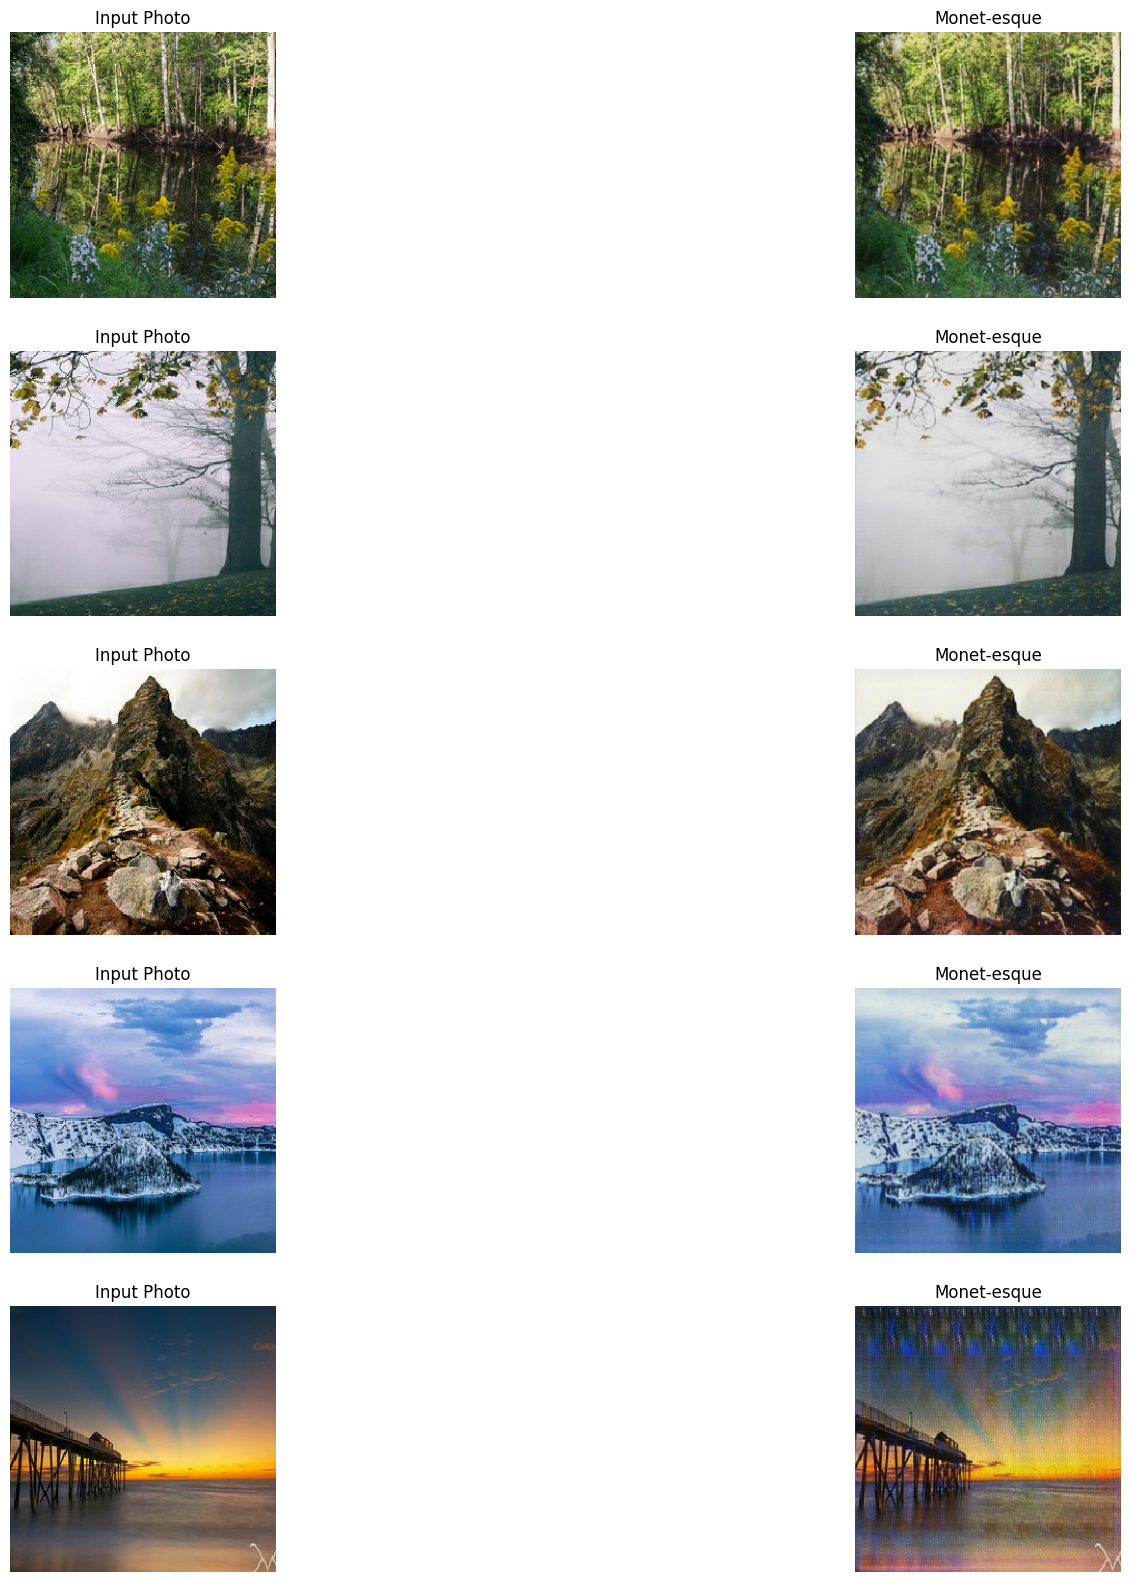

In [32]:
_, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(pho_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Model 1

In this iteration, the filter size was reduced from 4x4 to 3x3. This had the most signifcant performance improvement effect and was used on subsequent model iterations going forward.

In [33]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size = 1

    down_stack = [
        downsample(64, 3, apply_instancenorm=False), # (bs, 128, 128, 64) i.e. (halved w & h, filters = output)
        downsample(128, 3), # (bs, 64, 64, 128)
        downsample(256, 3), # (bs, 32, 32, 256)
        downsample(512, 3), # (bs, 16, 16, 512)
        downsample(512, 3), # (bs, 8, 8, 512)
        downsample(512, 3), # (bs, 4, 4, 512)
        downsample(512, 3), # (bs, 2, 2, 512)
        downsample(512, 3), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 3, apply_dropout=True), # (bs, 2, 2, 1024) i.e. (doubled w & h, output = output of downsample layer + filters due to skip connections)
        upsample(512, 3, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 3, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 3), # (bs, 16, 16, 1024)
        upsample(256, 3), # (bs, 32, 32, 512) 
        upsample(128, 3), # (bs, 64, 64, 256)
        upsample(64, 3), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs = 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Reverse order ensures skip connections are applied in the correct sequence during the upsampling process. 
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    print(x.shape)

    return keras.Model(inputs=inputs, outputs=x)

In [34]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    #defines input layer , specifying image shape to be expected
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    #downsample layers that reduces spatial dimensions
    down1 = downsample(64, 3, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 3)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 3)(down2) # (bs, 32, 32, 256)
    
    #zero padding (add zero layers) to ensure spatial info presevation (avoid border effects)
    zero_pad1 = layers.ZeroPadding2D()(down3) #  (bs, 34, 34, 256) 
    
    #convolution layer that captures features
    conv = layers.Conv2D(512, 3, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    
    #instance normalization to normalize features
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    #Leaky relu activation to introduce non-linearity to allow model handle complex relationships, variability in data (can try out other activation functions)
    leaky_relu = layers.LeakyReLU()(norm1)

    #zero padding (add zero layers)(can change when training models)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)  
    
    #final convolution layer to produce output 
    last = layers.Conv2D(1, 3, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1) 
    print(last.shape)
    #model created with input layer and output
    return tf.keras.Model(inputs=inp, outputs=last)

In [35]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

(None, 256, 256, 3)
(None, 256, 256, 3)
(None, 32, 32, 1)
(None, 32, 32, 1)


In [36]:
# Set up optimizers (can change during training)
with strategy.scope():    
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [37]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [38]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((mon_ds, pho_ds)),
    epochs=25
)

Epoch 1/25


2024-02-26 00:28:06.025744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


300/300 [==============================] - 139s 107ms/step - monet_gen_loss: 6.0144 - photo_gen_loss: 6.3431 - monet_disc_loss: 0.6067 - photo_disc_loss: 0.5389
Epoch 2/25
300/300 [==============================] - 32s 107ms/step - monet_gen_loss: 3.9368 - photo_gen_loss: 4.1178 - monet_disc_loss: 0.6805 - photo_disc_loss: 0.6453
Epoch 3/25
300/300 [==============================] - 33s 108ms/step - monet_gen_loss: 3.3332 - photo_gen_loss: 3.4815 - monet_disc_loss: 0.6774 - photo_disc_loss: 0.6398
Epoch 4/25
300/300 [==============================] - 32s 107ms/step - monet_gen_loss: 3.2450 - photo_gen_loss: 3.4124 - monet_disc_loss: 0.6585 - photo_disc_loss: 0.6174
Epoch 5/25
300/300 [==============================] - 32s 107ms/step - monet_gen_loss: 3.1813 - photo_gen_loss: 3.3428 - monet_disc_loss: 0.6599 - photo_disc_loss: 0.6339
Epoch 6/25
300/300 [==============================] - 32s 107ms/step - monet_gen_loss: 3.1738 - photo_gen_loss: 3.3446 - monet_disc_loss: 0.6319 - photo_di

## Visualize

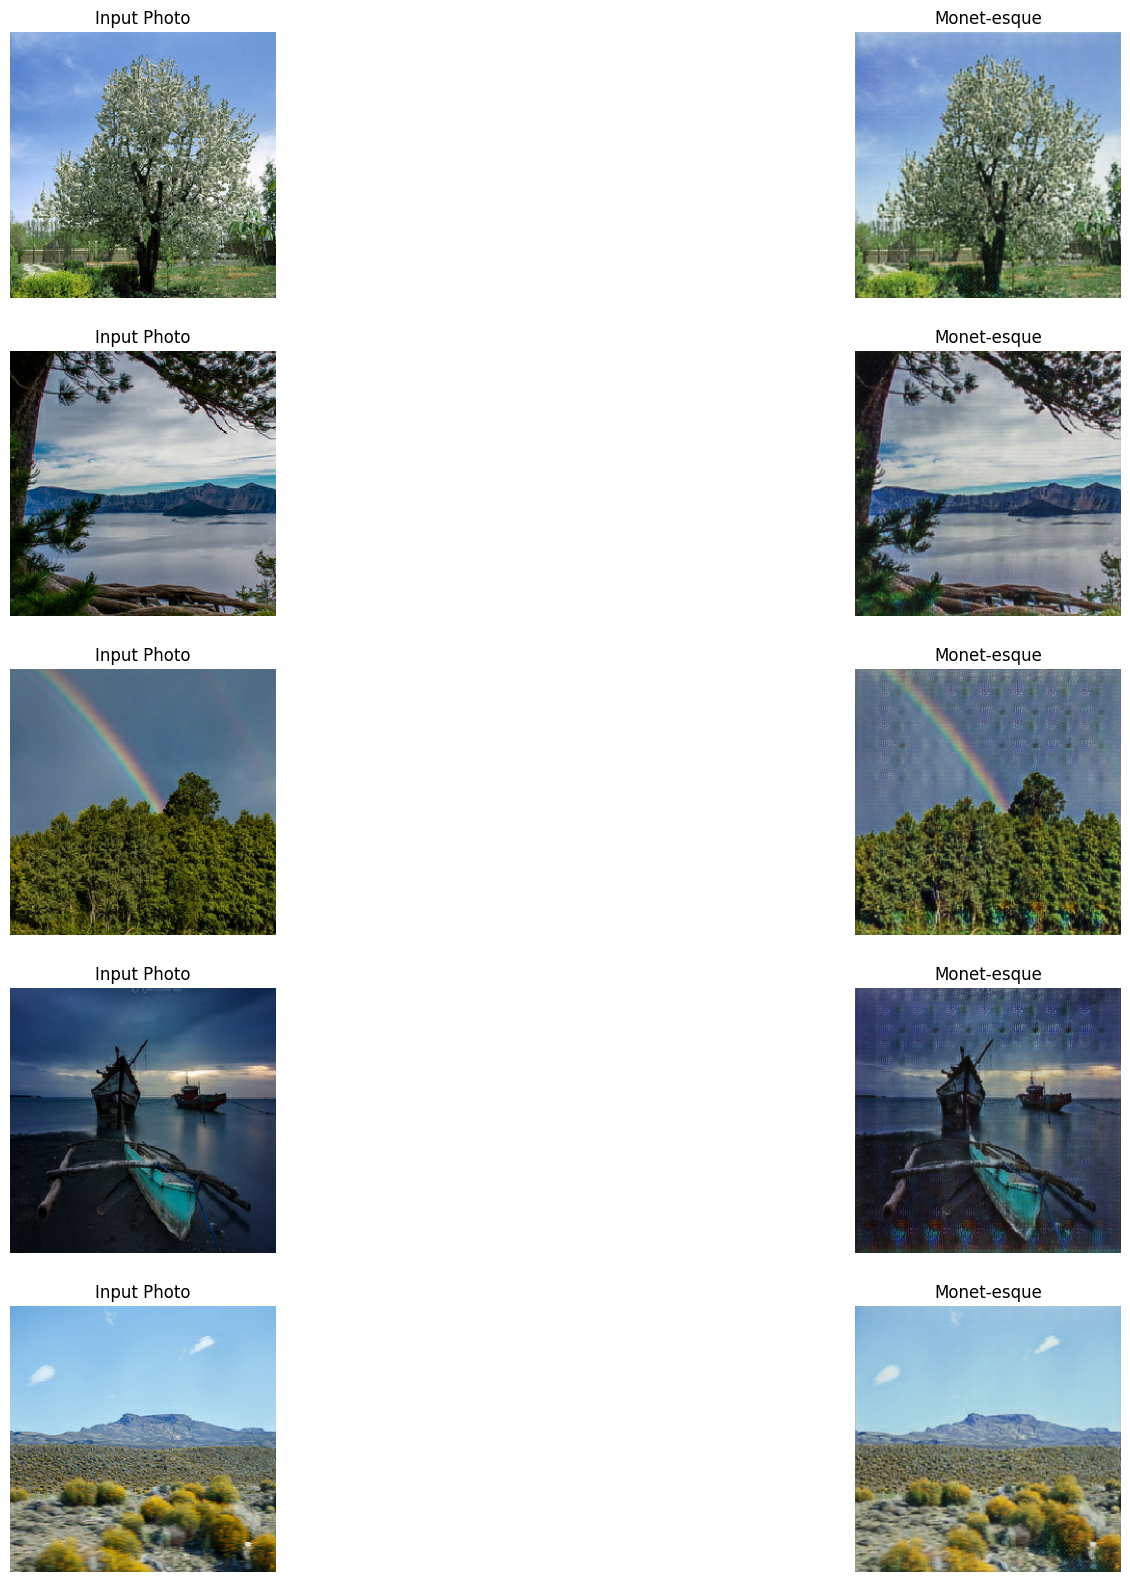

In [39]:
_, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(pho_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Model 2

In this iteration, I experimented with a different architecture in the Upsample stack within the Generator and subsequently the Downsample stack within the Discriminator. 1 upsample layer was added to the former component and 1 downsample layer to the latter component to equalize sizing and layers.

In [40]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size = 1

    down_stack = [
        downsample(64, 3, apply_instancenorm=False), # (bs, 128, 128, 64) i.e. (halved w & h, filters = output)
        downsample(128, 3), # (bs, 64, 64, 128)
        downsample(256, 3), # (bs, 32, 32, 256)
        downsample(512, 3), # (bs, 16, 16, 512)
        downsample(512, 3), # (bs, 8, 8, 512)
        downsample(512, 3), # (bs, 4, 4, 512)
        downsample(512, 3), # (bs, 2, 2, 512)
        downsample(512, 3), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 3, apply_dropout=True), # (bs, 2, 2, 1024) i.e. (doubled w & h, output = output of downsample layer + filters due to skip connections)
        upsample(512, 3, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 3, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 3), # (bs, 16, 16, 1024)
        upsample(256, 3), # (bs, 32, 32, 512) 
        upsample(128, 3), # (bs, 64, 64, 256)
        upsample(64, 3), # (bs, 128, 128, 128)
        upsample(32, 3), # (bs, 256, 256, 64)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs = 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Reverse order ensures skip connections are applied in the correct sequence during the upsampling process. 
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    print(x.shape)

    return keras.Model(inputs=inputs, outputs=x)

In [41]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    #defines input layer , specifying image shape to be expected
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    #downsample layers that reduces spatial dimensions
    down1 = downsample(32, 3, False)(x) # (bs, 256, 256, 32)
    down2 = downsample(64, 3)(down1) # (bs, 128, 128, 64)
    down3 = downsample(128, 3)(down2) # (bs, 64, 64, 128)
    down4 = downsample(256, 3)(down3) # (bs, 32, 32, 256)
    
    #zero padding (add zero layers) to ensure spatial info presevation (avoid border effects)
    zero_pad1 = layers.ZeroPadding2D()(down3) #  (bs, 34, 34, 256) 
    
    #convolution layer that captures features
    conv = layers.Conv2D(512, 3, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    
    #instance normalization to normalize features
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    #Leaky relu activation to introduce non-linearity to allow model handle complex relationships, variability in data (can try out other activation functions)
    leaky_relu = layers.LeakyReLU()(norm1)

    #zero padding (add zero layers)(can change when training models)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)  
    
    #final convolution layer to produce output 
    last = layers.Conv2D(1, 3, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1) 
    print(last.shape)
    #model created with input layer and output
    return tf.keras.Model(inputs=inp, outputs=last)

In [42]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

(None, 256, 256, 3)
(None, 256, 256, 3)
(None, 32, 32, 1)
(None, 32, 32, 1)


In [45]:
# Set up optimizers (can change during training)
with strategy.scope():    
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [46]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [47]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((mon_ds, pho_ds)),
    epochs=25
)

Epoch 1/25


2024-02-26 00:51:31.011648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


300/300 [==============================] - 138s 105ms/step - monet_gen_loss: 6.1521 - photo_gen_loss: 6.3210 - monet_disc_loss: 0.5749 - photo_disc_loss: 0.5691
Epoch 2/25
300/300 [==============================] - 32s 105ms/step - monet_gen_loss: 4.2070 - photo_gen_loss: 4.3456 - monet_disc_loss: 0.6887 - photo_disc_loss: 0.6551
Epoch 3/25
300/300 [==============================] - 32s 106ms/step - monet_gen_loss: 3.5082 - photo_gen_loss: 3.6772 - monet_disc_loss: 0.6765 - photo_disc_loss: 0.6447
Epoch 4/25
300/300 [==============================] - 32s 105ms/step - monet_gen_loss: 3.2386 - photo_gen_loss: 3.3573 - monet_disc_loss: 0.6480 - photo_disc_loss: 0.6288
Epoch 5/25
300/300 [==============================] - 32s 106ms/step - monet_gen_loss: 3.2323 - photo_gen_loss: 3.3418 - monet_disc_loss: 0.6472 - photo_disc_loss: 0.6218
Epoch 6/25
300/300 [==============================] - 32s 106ms/step - monet_gen_loss: 3.2230 - photo_gen_loss: 3.3357 - monet_disc_loss: 0.6362 - photo_di

## Visualize

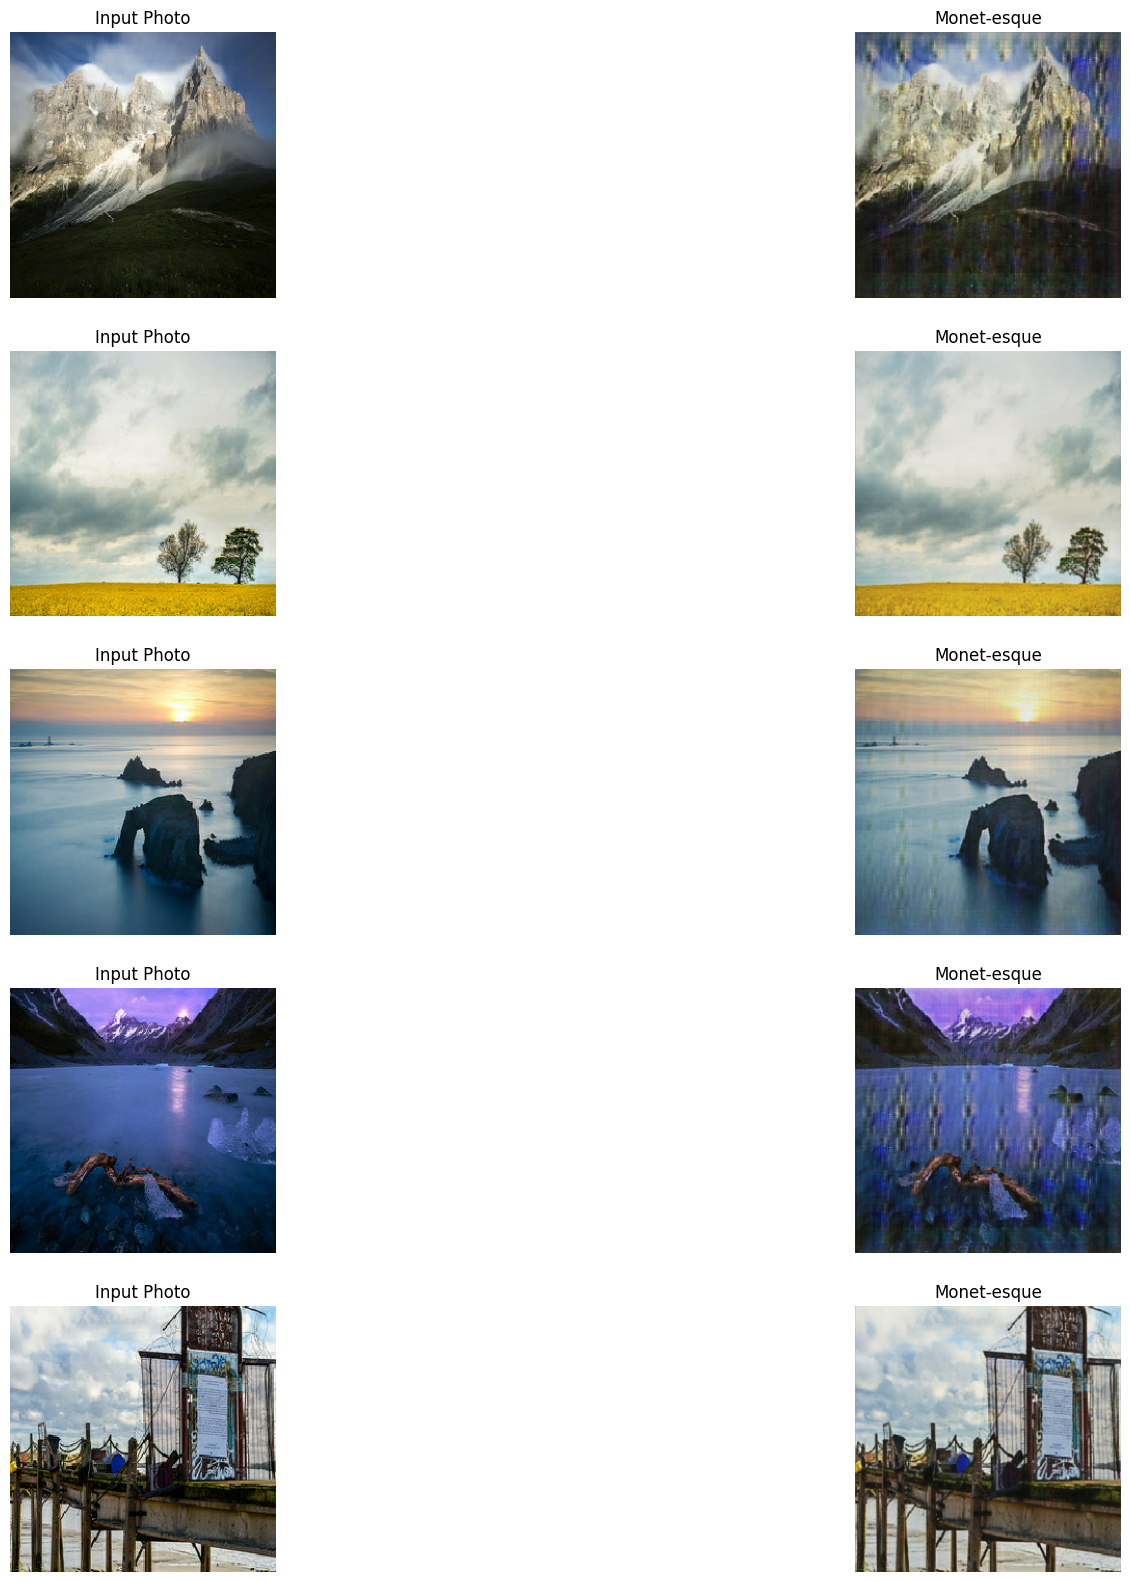

In [48]:
_, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(pho_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Set up submission files

In [49]:
import PIL
os.chdir("/kaggle/working")
! mkdir ../images

In [37]:
#os.chdir("/kaggle/working/model1")
i = 1
for img in pho_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [39]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/images.zip'

# Results and analysis

A number of different models were run to create a generative model that could create Monet style paintings from real images utilizing Amy Jang's architecture as a baseline. From that baseline, various hyperparameter tuning, different architectures, and application of other techniques to improve output and overall performance (measured by MFID or Memorization-informaed Frechet Inception Distance). A summary of the original parameters, models tested, and best model parameters can be found in the tables below.

In all, over 8 iterations of models were trained with a TPU VM v3-8 accelerator on 300 monet images. Amy's baseline architecture utilized a UNET architecture for the Generator, which consists of an encoder (downsampler) and decoder (upsampler). Something that was not originally added in the preprocessing was some data augmentation. Given that there were only 300 Monet images and over 7000 real images to perform style transfer, I decided to utilize some data augementation techniques which included resizing to a larger pixel grid and then randomly cropping & mirroring to artificially create new training data. This contributed a strong baseline performance ~85 that I could continue to improve on.

Each block in the encoder consisted of the following layers: Convolution ->  Instance normalization -> Leaky ReLU. Each block in the decoder consisted of the following layers: Transposed convolution -> Instance normalization -> Dropout (applied to the first 3 blocks) -> ReLU. The Dropout value was valued between 0.5 and 0.2. With the reduction to 0.2,runtime and submission took significantly longer and exceeded the competition's runtime limits of 300 minutes. Due to this it was unable to be scored, and therefore the dropout value was reverted back to 0.5. Additionally, the decoder final activation function was tested between ReLu and Leaky Relu, and ReLu had slightly better performance with a lower MFID score. Some experimentation with the stride values were performed, however it was determined the best performance remained in the baseline value of 2, where the filter was applied to every other pixel. 

When putting together the Generator, a couple of hyperparameters that were tested for were filter sizes and the last layer activation function. The baseline filter size was a 4x4 but a 3x3 sized filter significantly improved performance. In fact, the reduction in filter size had the largest impact in overall model performance. Additionally, the last layer's activation layer was tested with ReLu,Sigmoid, and Tanh. Tanh proved superior and through additional research I learned, that ReLu is often used more for hidden layers and almost never for output layers. 

Piggybacking on the improved performance from the reduced filter size in the Generator, I also applied it the Discriminator which did help but not at the same magnitude as in the Generator.

I also varied the architecture of the Generator and Discriminator by adding an additional upsample layer in the former and an additional downsample layer in the former. It did not change the performance of the model by much and proved the addition of complexity does not always serve to benefit the end result. 

Lastly, I experimented with the optimizer between Adam and RMSprop. There are a few important differences between RMSProp with momentum and Adam: RMSProp with momentum generates its parameter updates using a momentum on the rescaled gradient, whereas Adam updates are directly estimated using a running average of first and second moment of the gradient.

In [50]:
import pandas as pd
og_para = pd.DataFrame({'CycleGAN component':['Downsample','Upsample', 'Generator',"Discriminator", "Overall" ],
                       'Stride':[2,2,2,1,'-'],
                       'Filter size': [4,4,4,4,'-'],
                       'Activation Function':['Leaky ReLu', "ReLu",'Tanh','Leaky ReLu','-'],
                       'Regularization':["N/A", "Dropout", "N/A", "N/A",'-'],
                       'Regularization Value': ['N/A', 0.5, "N/A", "N/A",'-'],
                       "# of Layers":[3,3,'8 Downsample, 7 upsample', '3 downsample','-'],
                       'Optimizer':['-','-','-','-','Adam'],
                       'Epoch':['-','-','-','-',25]})
print('Baseline Parameters')
display(og_para)

Baseline Parameters


CycleGAN component Stride Filter size Activation Function Regularization  \
0         Downsample      2           4          Leaky ReLu            N/A   
1           Upsample      2           4                ReLu        Dropout   
2          Generator      2           4                Tanh            N/A   
3      Discriminator      1           4          Leaky ReLu            N/A   
4            Overall      -           -                   -              -   

  Regularization Value               # of Layers Optimizer Epoch  
0                  N/A                         3         -     -  
1                  0.5                         3         -     -  
2                  N/A  8 Downsample, 7 upsample         -     -  
3                  N/A              3 downsample         -     -  
4                    -                         -      Adam    25

In [52]:
tuning_sum = pd.DataFrame({
 'Model':[1,2,3,4,5,6,7,8,9,10],
 'Changed hyperparameter':['Addition of Data Augmentation','Generator filter size','Generator Activation Function','Architecture',"Discriminator Filter size",
                  'Stride','Upsample Activation Function','Upsample Dropout value', "Optimizer", "Optimizer"],
 'New Value':['random crop + mirror','3x3','ReLu','+1 upsample Gen & +1 downsample Disc', '3x3',4,'LeakyReLu',0.2,"AdamW", "RMSprop"],
 "Public Score":[85.54,69.04,111.62,70.86,
              65.45, 115.46, 71.16,"N/A","N/A","N/A"],
 "Rank":[5,2,6,3,
         1,7,4,8,9,10
        ]

 })
print('Hyperparameter tuning summary')
display(tuning_sum)

Hyperparameter tuning summary


Model         Changed hyperparameter                             New Value  \
0      1  Addition of Data Augmentation                  random crop + mirror   
1      2          Generator filter size                                   3x3   
2      3  Generator Activation Function                                  ReLu   
3      4                   Architecture  +1 upsample Gen & +1 downsample Disc   
4      5      Discriminator Filter size                                   3x3   
5      6                         Stride                                     4   
6      7   Upsample Activation Function                             LeakyReLu   
7      8         Upsample Dropout value                                   0.2   
8      9                      Optimizer                                 AdamW   
9     10                      Optimizer                               RMSprop   

  Public Score  Rank  
0        85.54     5  
1        69.04     2  
2       111.62     6  
3        70.86     3  
4        65.45     1  
5       115.46     7  
6        71.16     4  
7          N/A     8  
8          N/A     9  
9          N/A    10

In [53]:
best_para = pd.DataFrame({'CycleGAN component':['Downsample','Upsample', 'Generator',"Discriminator", "Overall" ],
                       'Stride':[2,2,2,1,'-'],
                       'Filter size': [3,3,3,3,'-'],
                       'Activation Function':['Leaky ReLu', "ReLu",'Tanh','Leaky ReLu','-'],
                       'Regularization':["N/A", "Dropout", "N/A", "N/A",'-'],
                       'Regularization Value': ['N/A', 0.5, "N/A", "N/A",'-'],
                       "# of Layers":[3,3,'8 Downsample, 7 upsample', '3 downsample','-'],
                       'Optimizer':['-','-','-','-','Adam'],
                       'Epoch':['-','-','-','-',25]})
print("Best model parameters")
display(best_para)

Best model parameters


CycleGAN component Stride Filter size Activation Function Regularization  \
0         Downsample      2           3          Leaky ReLu            N/A   
1           Upsample      2           3                ReLu        Dropout   
2          Generator      2           3                Tanh            N/A   
3      Discriminator      1           3          Leaky ReLu            N/A   
4            Overall      -           -                   -              -   

  Regularization Value               # of Layers Optimizer Epoch  
0                  N/A                         3         -     -  
1                  0.5                         3         -     -  
2                  N/A  8 Downsample, 7 upsample         -     -  
3                  N/A              3 downsample         -     -  
4                    -                         -      Adam    25

# Conclusion
In this project, I attempted to adapt Amy Jang's baseline implementation of CycleGan to improve it's performance to generate Monet style paintings. The original implmentation utilizes a CycleGan architecture to perform style transfer of the Monet paintings to reference photos of real images. Hyperparameters and additional techniques that were taken into consideration for optimization included:
* Data Augementation addition
* Filter Sizing
* Activation functions in the different CycleGAN components
* Stride values
* Regularization values
* Optimizers
* CycleGAN Architecture

Given the time to experiment as part of a weekly assignment for the University of Colorado, Boulder course "Introduction to Deep Learning", most of the optimization procedure pointed to a lot of the baseline implementation performing well. The main improvers I was able to identify as part of my experimentation was the reduction of the filter sizing and the addition of Data augmentation. Data Augmentation consisted off increasing image pixel grid, randomly cropping from larger image, and randomly mirroring. This set us at a decent baseline performance metric of 85.54 which would have already met passing criteria for the weekly assignment. From there, across the entire model,reducing the filter sizing from 4x4 to 3x3 dropped the performance metric to 65.45. This reduced runtime to ~ 40 mins. 

Additionally, I made some changes to how the Generator was constructed. First changes were made to the activation functions for the overall Generator and later the upsample method.  The overall Generator activation function was changed from Leaky ReLu to ReLu. Unfortunately, it performed worse than the baseline model with a score over the passing criteria for the assigment (>100). Next, I decided to adjust hyperparameters in the upsample method. First, I changed the activation function from ReLu to Leaky ReLu. While this did improve performance from the baseline model, it also increased run time to nearly 5 hours. Due to this draw back, and the fact that the filter sizing optimization increased performance by a larger magnitude I decided to revert to the original activation function. Lastly, I adjusted the dropout value in the upsample method from 0.5 to 0.2. Unfortunately, this caused a runtime limit reached set by the competition and wasn't able to be scored. Given the results of these adjustments, all hyperparameters were reverted to the original values.

I also took an opportunity to experiment with a different architecture to see how it would affect performance. I added 1 upsample layer to the Generator and 1 downsample layer to the Discriminator. This addition did improve performance from the baseline model and did not affect runtime by much, however the reduced filter sizing still resulted in better performance by magnitude. Given this information, I decided against this new architecture to reduce load on computing capabilities and maintian simpler complexity.

Lastly, I tried out a couple of overall changes including different stride values and optimizers. I tried a stride value of 4 from the original 2, which essentially ended up halving the runtime. It's performance suffered significantly and scored higher than the passing criteria for the assignment. RMSprop and AdamW were used as an alternate optimizers but they significantly increased run time ,reached competition timeout limit, and were unable to be scored. To tune for better runtime, the optimizer was reverted to the Adam method. 

With the best model score at 65.45, the adjust model performed well below the passing criteria for this assignment. There is still room for improvement to be made in this model and in the future I would like the try out the following optimizations:
* alternate regularizations methods in Upsample
* different architecture
* alternate optimizers
* additional data augmentation techniques
* Adjusting presaved models
* training for longer epochs

Thank you for taking time to look at my notebook.


# References

* [CycleGAN tensorflow documentation](https://www.tensorflow.org/tutorials/generative/cyclegan)
* [pix2pix tensorflow documentation](https://www.tensorflow.org/tutorials/generative/pix2pix)
* [Image Segmentation documentation](https://www.tensorflow.org/tutorials/images/segmentation)
* [Amy Jang's Kaggle Notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook)
* [U-Net architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
* [Instance vs Batch Normalization](https://www.baeldung.com/cs/instance-vs-batch-normalization)
* [Activation Functions](https://www.v7labs.com/blog/neural-networks-activation-functions#why-are-deep-neural-networks-hard-to-train)